In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Activation,Dense,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Model
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. \
import matplotlib.pyplot as plt

TRAIN_DIR = '/content/drive/My Drive' #path of dataset
IMG_SIZE =128
input_shape=(IMG_SIZE,IMG_SIZE,3)

In [10]:
train_data=np.load("/content/drive/My Drive/plantvillage128_40_train.npy",allow_pickle=True)
valid_data = np.load("/content/drive/My Drive/plantvillage128_40_valid.npy",allow_pickle=True)

In [11]:
train_y=np.array([i[1] for i in train_data]).reshape(-1,1)
train_x=np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

valid_y=np.array([i[1] for i in valid_data]).reshape(-1,1)
valid_x=np.array([i[0] for i in valid_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

train_x.shape

(16000, 128, 128, 3)

In [15]:
vgg16 = keras.applications.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

from keras.layers import GlobalAveragePooling2D
output =  vgg16.layers[-1].output
avg_pool = GlobalAveragePooling2D()(output)
output = tf.keras.layers.Flatten()(avg_pool)
vgg16_model = Model(vgg16.input, output)

vgg16_model.trainable = False
for layer in vgg16_model.layers:
    layer.trainable = False

In [6]:
vgg16_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

In [21]:
from tensorflow.keras import optimizers
import time
model = Sequential()
model.add(vgg16_model)
model.add(Dense(512, activation='sigmoid', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(40, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


In [22]:
start=time.time()

vgg16_history1=model.fit(train_x,train_y,batch_size=128,epochs=0,validation_data=(valid_x,valid_y))
end=time.time()
model.summary()

Epoch 1/70
125/125 [==============================] - 14s 110ms/step - loss: 3.0981 - accuracy: 0.2104 - val_loss: 2.2415 - val_accuracy: 0.5989
Epoch 2/70
125/125 [==============================] - 13s 108ms/step - loss: 1.9360 - accuracy: 0.5178 - val_loss: 1.4104 - val_accuracy: 0.7300
Epoch 3/70
125/125 [==============================] - 13s 108ms/step - loss: 1.3391 - accuracy: 0.6574 - val_loss: 0.9959 - val_accuracy: 0.7819
Epoch 4/70
125/125 [==============================] - 13s 108ms/step - loss: 1.0101 - accuracy: 0.7319 - val_loss: 0.7703 - val_accuracy: 0.8165
Epoch 5/70
125/125 [==============================] - 13s 108ms/step - loss: 0.8143 - accuracy: 0.7791 - val_loss: 0.6403 - val_accuracy: 0.8319
Epoch 6/70
125/125 [==============================] - 14s 108ms/step - loss: 0.6825 - accuracy: 0.8108 - val_loss: 0.5514 - val_accuracy: 0.8521
Epoch 7/70
125/125 [==============================] - 13s 108ms/step - loss: 0.5926 - accuracy: 0.8297 - val_loss: 0.4891 - val_ac

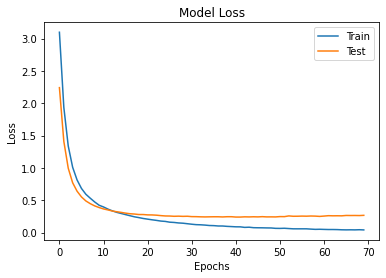

In [23]:
plt.plot(vgg16_history1.history['loss'])
plt.plot(vgg16_history1.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

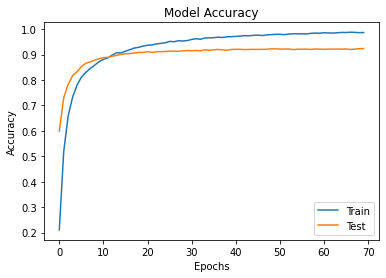

In [24]:
plt.plot(vgg16_history1.history['accuracy'])
plt.plot(vgg16_history1.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [33]:
model.save('/content/drive/My Drive/vgg16_70e_0.4*0.4.h5')

In [8]:
model = keras.models.load_model('/content/drive/My Drive/vgg16_70e_0.4*0.4.h5')

In [27]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = model.predict(valid_x)

y_predictions = [np.argmax(i) for i in y_pred]

In [28]:
import pandas as pd
pd.set_option('display.max_columns',None)
confusion_matrix = pd.DataFrame(confusion_matrix(valid_y,y_predictions))

confusion_matrix.to_csv('/content/drive/My Drive/confusion_matrix.csv')

In [29]:
print(classification_report(valid_y,y_predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       200
           1       0.94      0.97      0.96       200
           2       0.96      0.97      0.97       200
           3       0.93      0.93      0.93       200
           4       0.96      0.94      0.95       200
           5       0.97      0.95      0.96       200
           6       0.97      0.97      0.97       200
           7       0.90      0.90      0.90       200
           8       0.99      0.98      0.99       200
           9       0.89      0.93      0.91       200
          10       0.99      1.00      0.99       200
          11       0.92      0.90      0.91       200
          12       0.91      0.95      0.93       200
          13       0.96      0.98      0.97       200
          14       0.99      0.97      0.98       200
          15       0.99      0.99      0.99       200
          16       0.97      0.90      0.94       200
          17       0.93    

In [26]:
classification_report

""
